In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [66]:
train = pd.read_csv('../input/customerattritionprediction/train.csv', index_col = 'ID')
test = pd.read_csv('../input/customerattritionprediction/test.csv', index_col = 'ID')
train.head()

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,CustomerAttrition
ID,,,,,,,,,,,,,,,
B60LHTZLLPFU4IULNPUF,Female,No,No,Yes,48,Yes,Wifi Broadband,No,Yes,Yes,No,Check,96.259802,4628.129119,Yes
1RUJ7ONYZHYTWKOKO1SD,Male,No,Yes,No,45,Yes,Wifi Broadband,No,No,No,Yes,Bank,18.876470,922.085998,No
DZ9EEOQWSN0MYCBUPAM5,Male,Yes,Yes,No,59,Yes,Wifi Broadband,Yes,No,Yes,No,Card,106.016057,6205.891129,Yes
YZ43L1UQUQACTL1PXXZG,Male,No,No,No,14,Yes,Wifi Broadband,No,No,No,No,Check,80.108839,1248.655391,No
6P28152QGF60PDLSCB9M,Female,No,Yes,Yes,25,Yes,Wifi Broadband,No,Yes,No,Yes,Check,51.529773,1285.321277,No


In [67]:
#Replace the only N/A value with the column's average 
test['GrandPayment']['TNU13T8BB6KQZTN515SK'] = 2290.544207

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
#Remove the N/A rows
print(len(train.index))
print(len(train[train.isnull().any(axis = 1)].index))
train = train.dropna()
print(len(train.index))

6328
0
6328


In [72]:
features = train.columns[:len(train.columns) - 1]
cont_features = ['ServiceSpan','QuarterlyPayment', 'GrandPayment']
prediction = train.columns[len(train.columns) - 1]
pos_train = train[train[prediction] == 'Yes']

X = train.drop(labels = prediction, axis = 1)
y = train[prediction]

cat_features = X.columns[X.dtypes == object].tolist()

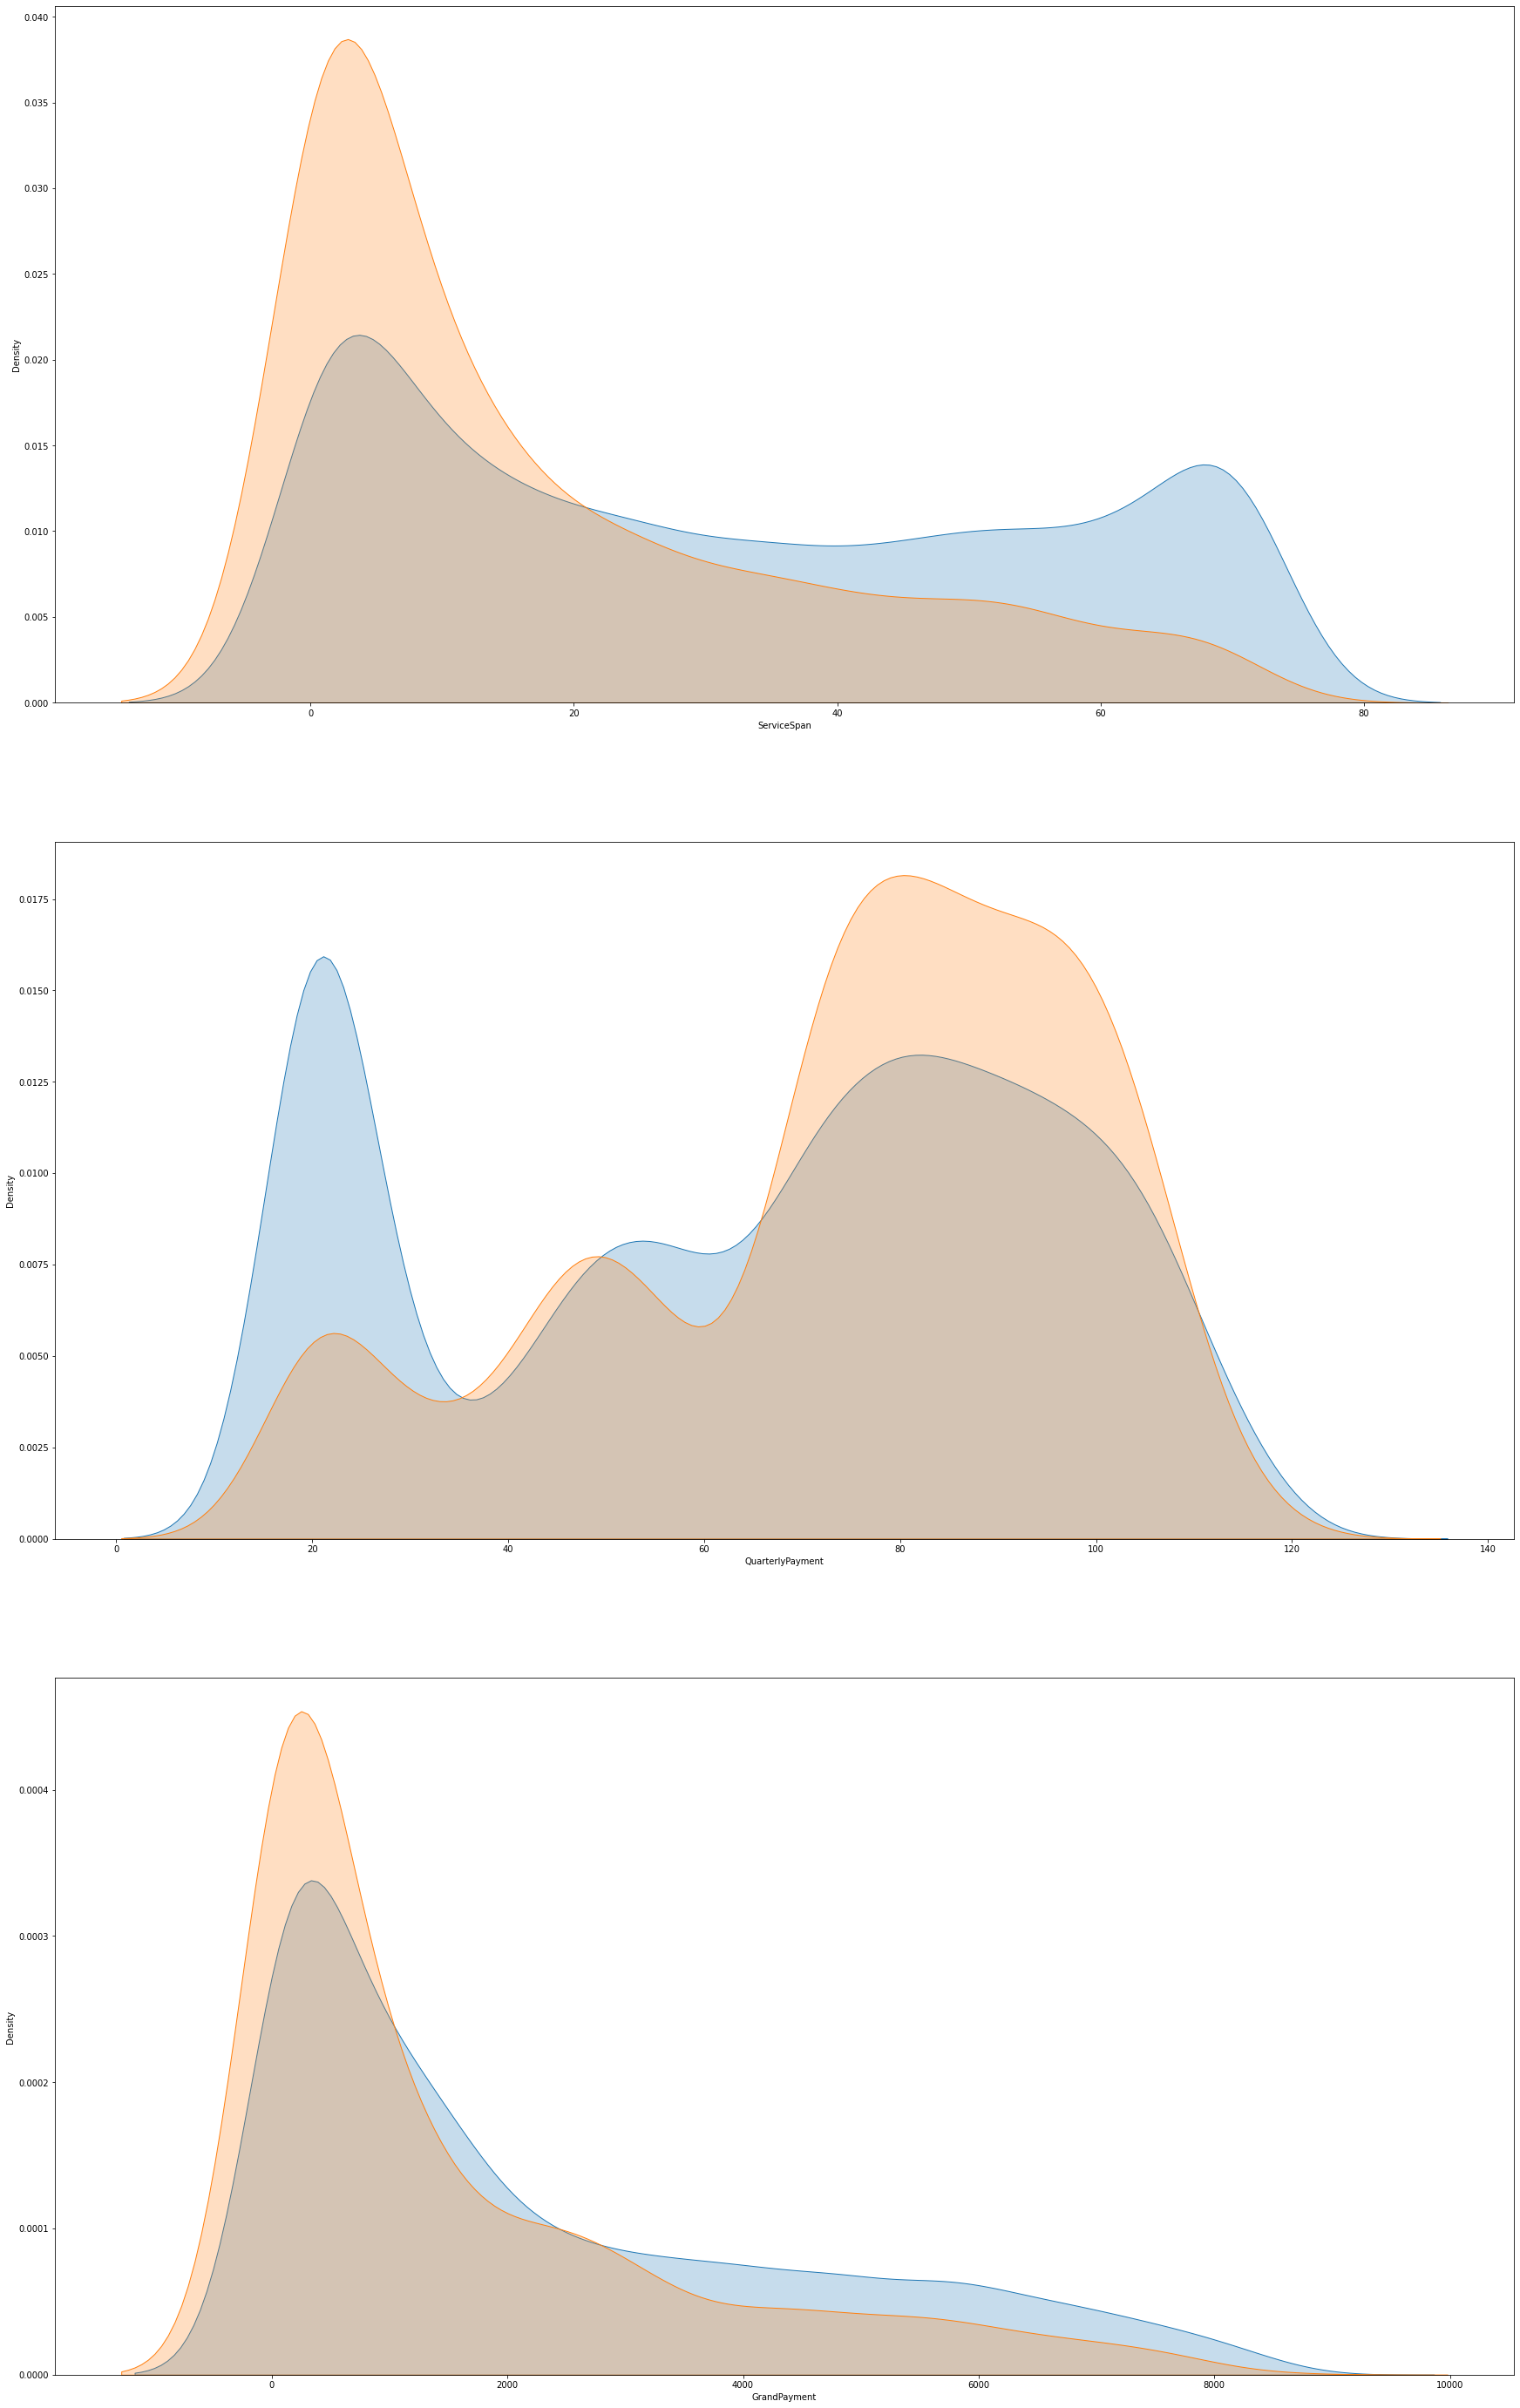

In [73]:
fig, ax = plt.subplots(len(cont_features), 1, figsize=(30, 50))

for (i,feature) in enumerate(cont_features):
    sns.kdeplot(data=train,  x=feature, ax=ax[i], shade=True, hue_order=prediction)
    sns.kdeplot(data=pos_train,  x=feature, ax=ax[i], shade=True, hue_order=prediction)
plt.show()

# Encode Data

In [74]:
le = LabelEncoder()
y = le.fit_transform(y)

for cat_f in cat_features:
    encoder = LabelEncoder()
    tot = X[cat_f].append(test[cat_f])
    encoder.fit(tot)
    X[cat_f] = encoder.transform(X[cat_f])
    test[cat_f] = encoder.transform(test[cat_f])

# Sampling

In [75]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler


# define resampling
over = RandomOverSampler(sampling_strategy=0.98)
under = RandomUnderSampler(sampling_strategy=1)

# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])

X_sampled, y_sampled = pipeline.fit_resample(X, y)

In [76]:
X_sampled.shape

(9110, 14)

# View the Class Distribution before and after Sampling

In [77]:
fig, ax = plt.subplots(len(cat_features), 2, figsize=(20, 60))

for (i,feature) in enumerate(cat_features):
    
    #Before Resampling
    sns.countplot(x=feature, hue=y, ax=ax[i][0], data=X)
    
    #After Resampling
    sns.countplot(x=feature, hue=y_sampled, ax=ax[i][1], data=X_sampled)
    
    for p in ax[i][1].patches:
        ax[i][1].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+50))
        
    for p in ax[i][0].patches:
        ax[i][0].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+50))

Error in callback <function flush_figures at 0x7ffb4951fc20> (for post_execute):


KeyboardInterrupt: 

In [78]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold

def eval_model(model):
    cv_rep = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    y_pred = cross_val_predict(model, X_sampled, y_sampled, cv= 10)
    cm = confusion_matrix(y_sampled, y_pred)
    print("Accuracy: " + str(accuracy_score(y_sampled, y_pred)))
    print("Recall: " + str(recall_score(y_sampled, y_pred, average=None)))
    print("Precision: " + str(precision_score(y_sampled, y_pred, average=None)))
    print(cm)
    plt.imshow(cm, cmap='binary')
    print("f1-score: " + str(f1_score(y_sampled, y_pred, average='weighted')))
    
def grid_search(model,parameters):
    grid_search = GridSearchCV(estimator = model, param_grid = parameters,scoring = 'accuracy',cv = 10, n_jobs=-1, verbose=5)
    grid_search = grid_search.fit(X_sampled, y_sampled)
    print(grid_search.best_params_)
    print(grid_search.best_score_)

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier()
parameters = [{
          'n_estimators' : [250,300],
          'criterion': ['entropy', 'gini'],
          'max_features': ['auto', 'log2']
          }]
grid_search(random, parameters)
#eval_model(clf1)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


KeyboardInterrupt: 

Accuracy: 0.9077936333699231
Recall: [0.84500549 0.97058178]
Precision: [0.96635702 0.86229764]
[[3849  706]
 [ 134 4421]]
f1-score: 0.9074286847397269


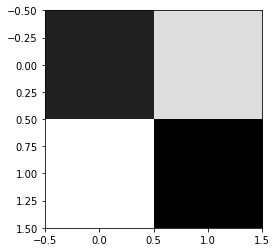

In [82]:
random = RandomForestClassifier()
eval_model(random)

Accuracy: 0.9071350164654226
Recall: [0.84368825 0.97058178]
Precision: [0.96630626 0.86128969]
[[3843  712]
 [ 134 4421]]
f1-score: 0.9067596783353719


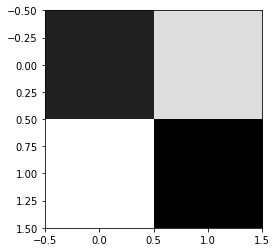

In [81]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier()
eval_model(brf)

Accuracy: 0.921185510428101
Recall: [0.87749726 0.96487377]
Precision: [0.9615107  0.88734101]
[[3997  558]
 [ 160 4395]]
f1-score: 0.9210347924110499


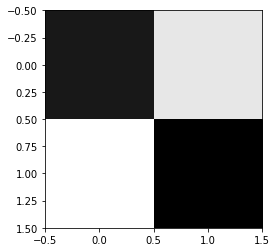

In [83]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
eval_model(etc)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
stack2 = StackingClassifier(estimators=[('randomforest', random), ('extratree', etc), ('bal_randomforest', brf)], final_estimator=LogisticRegression())
eval_model(stack2)

# Exporting the Prediction

In [ ]:
random.fit(X, y)
y_pred = random.predict(test)

In [ ]:
y_pred = pd.DataFrame({'CustomerAttrition': y_pred})['CustomerAttrition'].map({1:'Yes', 0:'No'})

In [ ]:
y_pred

In [ ]:
output = pd.DataFrame({'ID': test.index, 'CustomerAttrition': y_pred})
output.to_csv('rf-classifier.csv', index=False)